# Actor-Critic Training for Attack-Defense Tree Time Environment

## Training Process
1. Environment setup and configuration
2. Agent initialization with neural networks
3. Multi-agent training loop with episode collection
4. Performance monitoring and visualization
5. Model saving and evaluation

In [1]:
# Import Required Libraries
import numpy as np
import torch
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import sys
from tqdm.notebook import tqdm

# Add parent directory to path to find the core module
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import our custom modules
from core.adt_time_env import AttackDefenseTreeMultiAgentTimeEnv
from core.adt_actor_critic import ADTAgent, TrainingMetrics

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Consistent random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
# set device
device_name = "cpu" # Force CPU usage for small models
device = torch.device(device_name)
print(f"Using device: {device}")

PyTorch version: 2.7.1+cu126
CUDA available: True
Using device: cpu


## Environment Setup and Configuration

First, let's create the multi-agent environment and examine its properties.

In [2]:
print("🌍 Setting up ADT Multi-Agent Environment...")

# Create environment directly without wrappers to avoid reset issues
env_name = "34_env"
env_file = "envs/"+env_name+".json"
env = AttackDefenseTreeMultiAgentTimeEnv(env_file, render_mode=None)
print("✅ Environment created successfully!")

# Environment information
print(f"\n📊 Environment Information:")
print(f"Agents: {env.possible_agents}")
print(f"Action spaces: {env.action_spaces}")
print(f"Observation spaces: {env.observation_spaces}")

# Reset to get initial observations
obs, info = env.reset(seed=42)
print(f"\n🔍 Initial observation shapes:")
for agent, observation in obs.items():
    print(f"  {agent}: {observation.shape}")
print("✅ Environment reset working properly!")

# Get state and action dimensions
state_size = env.observation_spaces['attacker'].shape[0]
attacker_action_size = env.action_spaces['attacker'].n
defender_action_size = env.action_spaces['defender'].n

print(f"\n🧠 Network Dimensions:")
print(f"State size: {state_size}")
print(f"Attacker actions: {attacker_action_size}")
print(f"Defender actions: {defender_action_size}")
print(f"State variables: {env.state_vars}")
print(f"Number of state variables: {len(env.state_vars)}")

# Test a quick episode iteration
print(f"\n⚙️  Testing environment iteration...")
try:
    agent_count = 0
    for agent_name in env.agent_iter():
        agent_count += 1
        if agent_count > 2:  # Just test first 2 iterations
            break
        obs, reward, term, trunc, info = env.last()
        print(f"  Agent {agent_name}: obs shape {obs.shape}")
        env.step(0)  # Take a dummy action
    print("✅ Environment iteration working!")
except Exception as e:
    print(f"⚠️  Iteration warning: {e}")

🌍 Setting up ADT Multi-Agent Environment...
✅ Environment created successfully!

📊 Environment Information:
Agents: ['attacker', 'defender']
Action spaces: {'attacker': Discrete(20), 'defender': Discrete(14)}
Observation spaces: {'attacker': Box([ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1 -1 -1], [1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3], (24,), int32), 'defender': Box([ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1 -1 -1], [1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3], (24,), int32)}

🔍 Initial observation shapes:
  attacker: (24,)
  defender: (24,)
✅ Environment reset working properly!

🧠 Network Dimensions:
State size: 24
Attacker actions: 20
Defender actions: 14
State variables: ['root', 'current_player', 'N_6', 'N_8', 'N_3', 'N_9', 'N_11', 'N_7', 'N_13', 'N_10', 'N_12', 'N_4', 'N_2', 'N_5', 'N_1', 'N_100', 'N_101', 'N_102', 'N_103', 'N_104', 'N_105', 'N_106', 'attacker_time_remaining', 'defender_time_remaining']
Number of state

## Agent Initialization

Create the actor-critic agents for both attacker and defender with appropriate neural network architectures.

In [3]:
# Training hyperparameters
LEARNING_RATE = 3e-4 # Learning rate for the optimizer
GAMMA = 0.99 # Discount factor
HIDDEN_SIZE = 128 # Size of hidden layers in the neural networks
MAX_EPISODES = 5_000
UPDATE_FREQUENCY = 10  # Update policy every N episodes
PRINT_FREQUENCY = 1000  # Print stats every N episodes

# Epsilon exploration parameters
EPSILON_START = 0.99  # Starting epsilon for exploration
EPSILON_END = 0.01   # Final epsilon for exploration
EPSILON_DECAY = 5000 # Number of steps for epsilon decay

print("🤖 Initializing Actor-Critic Agents with Epsilon Exploration...")

# Create agents
attacker_agent = ADTAgent(
    state_size=state_size,
    action_size=attacker_action_size,
    agent_name='attacker',
    lr=LEARNING_RATE,
    gamma=GAMMA,
    hidden_size=HIDDEN_SIZE,
    device=device_name,
    epsilon_start=EPSILON_START,
    epsilon_end=EPSILON_END,
    epsilon_decay=EPSILON_DECAY
)

defender_agent = ADTAgent(
    state_size=state_size,
    action_size=defender_action_size,
    agent_name='defender',
    lr=LEARNING_RATE,
    gamma=GAMMA,
    hidden_size=HIDDEN_SIZE,
    device=device_name,
    epsilon_start=EPSILON_START,
    epsilon_end=EPSILON_END,
    epsilon_decay=EPSILON_DECAY
)

print(f"✅ Agents initialized with epsilon exploration!")
print(f"   Epsilon start: {EPSILON_START}")
print(f"   Epsilon end: {EPSILON_END}")
print(f"   Epsilon decay: {EPSILON_DECAY} steps")

# Initialize training metrics
metrics = TrainingMetrics()

print("📊 Model Summary:")
print("Attacker Agent:")
summary(attacker_agent.network, (state_size,), device=device_name)
print("Defender Agent:")
summary(defender_agent.network, (state_size,), device=device_name)

🤖 Initializing Actor-Critic Agents with Epsilon Exploration...
✅ Agents initialized with epsilon exploration!
   Epsilon start: 0.99
   Epsilon end: 0.01
   Epsilon decay: 5000 steps
📊 Model Summary:
Attacker Agent:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           3,200
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
              ReLU-4                  [-1, 128]               0
            Linear-5                   [-1, 64]           8,256
              ReLU-6                   [-1, 64]               0
            Linear-7                   [-1, 20]           1,300
            Linear-8                   [-1, 64]           8,256
              ReLU-9                   [-1, 64]               0
           Linear-10                    [-1, 1]              65
Total params: 3

## Training Helper Functions

Define utility functions for the training process.

In [4]:
def run_episode(env, attacker_agent, defender_agent, episode_num, max_steps=100):
    """
    Run episode with epsilon-greedy exploration enabled during training.
    """
    obs, info = env.reset()
    
    episode_data = {
        'attacker_reward': 0,
        'defender_reward': 0,
        'length': 0,
        'winner': None,
        'goal_achieved': False
    }
    
    # Track experiences for each agent separately
    agent_experiences = {
        'attacker': [],
        'defender': []
    }
    
    step_count = 0
    
    for agent_name in env.agent_iter():
        if step_count >= max_steps:
            break
            
        observation, reward, termination, truncation, info = env.last()
        episode_data[f'{agent_name}_reward'] += reward
        
        if termination or truncation:
            # Store final experience with terminal flag
            if step_count > 0 and agent_experiences[agent_name]:
                # Update last experience with final reward and terminal flag
                last_exp = agent_experiences[agent_name][-1]
                last_exp['reward'] = reward
                last_exp['done'] = True
            break
        
        step_count += 1
        episode_data['length'] = step_count
        
        available_actions = env.get_available_actions(agent_name)
        
        # Get action from appropriate agent (with epsilon exploration enabled)
        if agent_name == 'attacker':
            action, log_prob, value, _ = attacker_agent.get_action(
                observation.astype(np.float32), available_actions, deterministic=False
            )
        else:
            action, log_prob, value, _ = defender_agent.get_action(
                observation.astype(np.float32), available_actions, deterministic=False
            )
        
        # Store experience
        agent_experiences[agent_name].append({
            'state': observation.copy(),
            'action': action,
            'reward': 0,  # Will be updated with next iteration's reward
            'log_prob': log_prob,
            'value': value,
            'done': False
        })
        
        env.step(action)
    
    # Store all experiences in agent buffers
    for agent_name, experiences in agent_experiences.items():
        agent = attacker_agent if agent_name == 'attacker' else defender_agent
        for exp in experiences:
            agent.store_transition(
                state=exp['state'],
                action=exp['action'],
                reward=exp['reward'],
                log_prob=exp['log_prob'],
                value=exp['value'],
                done=exp['done']
            )
    
    episode_data['goal_achieved'] = env.goal_reached
    episode_data['winner'] = 'attacker' if episode_data['goal_achieved'] else 'defender'
    
    return episode_data


def print_training_stats(episode, metrics, attacker_agent, defender_agent, start_time):
    """Print training statistics including epsilon values."""
    current_time = time.time()
    elapsed_time = current_time - start_time
    
    # Get recent statistics
    recent_stats = metrics.get_recent_stats(window=100)
    
    print(f"\n{'='*80}")
    print(f"EPISODE {episode:4d} | Time: {elapsed_time/60:.1f}m")
    print(f"{'='*80}")
    
    if recent_stats:
        print(f"📊 Last 100 Episodes:")
        print(f"   🔥 Avg Attacker Reward: {recent_stats['avg_attacker_reward']:8.2f}")
        print(f"   🛡️ Avg Defender Reward: {recent_stats['avg_defender_reward']:8.2f}")
        print(f"   📏 Avg Episode Length:  {recent_stats['avg_episode_length']:8.2f} steps")
        print(f"   🏆 Attacker Win Rate:   {recent_stats['attacker_win_rate']:8.2%}")
        print(f"   🏆 Defender Win Rate:   {recent_stats['defender_win_rate']:8.2%}")
    
    # Show current epsilon values
    print(f"   🎯 Current Attacker ε:   {attacker_agent.get_epsilon():8.4f}")
    print(f"   🎯 Current Defender ε:   {defender_agent.get_epsilon():8.4f}")
    
    # Show recent losses if available
    if len(metrics.attacker_losses['total']) > 0:
        recent_att_loss = np.mean(metrics.attacker_losses['total'][-10:])
        recent_def_loss = np.mean(metrics.defender_losses['total'][-10:])
        print(f"   📉 Recent Attacker Loss: {recent_att_loss:8.4f}")
        print(f"   📉 Recent Defender Loss: {recent_def_loss:8.4f}")


# Create directories for saving models and metrics
os.makedirs('trained_models', exist_ok=True)
os.makedirs('training_logs', exist_ok=True)

print("✅ Training helper functions defined with epsilon exploration!")
print("📁 Directories created for saving models and logs")

✅ Training helper functions defined with epsilon exploration!
📁 Directories created for saving models and logs


## Main Training Loop

Execute the main training loop with experience collection and policy updates.

In [5]:
# Main Training Loop
print("🚀 Starting Actor-Critic Training!")
print("="*80)

# Clear any existing buffers to ensure clean start
attacker_agent.clear_episode_data()
defender_agent.clear_episode_data()

start_time = time.time()

for episode in tqdm(range(1, MAX_EPISODES + 1)):
    # Run episode and collect experience (with epsilon exploration)
    episode_data = run_episode(env, attacker_agent, defender_agent, episode)
    
    # Log episode data with current epsilon values
    metrics.log_episode(
        episode_data,
        attacker_epsilon=attacker_agent.get_epsilon(),
        defender_epsilon=defender_agent.get_epsilon()
    )
    
    # Update policies periodically
    if episode % UPDATE_FREQUENCY == 0:
        # Update attacker policy
        att_losses = attacker_agent.update_policy()
        if att_losses:
            metrics.log_losses('attacker', att_losses)
        
        # Update defender policy
        def_losses = defender_agent.update_policy()
        if def_losses:
            metrics.log_losses('defender', def_losses)
    
    # Print statistics including epsilon values
    if episode % PRINT_FREQUENCY == 0:
        print_training_stats(episode, metrics, attacker_agent, defender_agent, start_time)


# Save final models and metrics
print(f"\n💾 Saving metrics...")
metrics.save_metrics(f'training_logs/{env_name}_time_training_metrics.pkl')

total_time = time.time() - start_time
print(f"✅ Training completed in {total_time/60:.1f} minutes!")
print(f"📊 Total episodes: {len(metrics.episode_lengths)}")

# Show final exploration statistics
print(f"\n🎯 FINAL EXPLORATION STATISTICS:")
print(f"Final Attacker Epsilon: {attacker_agent.get_epsilon():.6f}")
print(f"Final Defender Epsilon: {defender_agent.get_epsilon():.6f}")
print(f"Attacker steps taken: {attacker_agent.steps_done}")
print(f"Defender steps taken: {defender_agent.steps_done}")

🚀 Starting Actor-Critic Training!


  0%|          | 0/5000 [00:00<?, ?it/s]


EPISODE 1000 | Time: 0.8m
📊 Last 100 Episodes:
   🔥 Avg Attacker Reward: -38476.40
   🛡️ Avg Defender Reward: -30469.80
   📏 Avg Episode Length:     55.40 steps
   🏆 Attacker Win Rate:      7.00%
   🏆 Defender Win Rate:     93.00%
   🎯 Current Attacker ε:     0.0136
   🎯 Current Defender ε:     0.0143
   📉 Recent Attacker Loss:   0.3071
   📉 Recent Defender Loss:   0.4502

EPISODE 2000 | Time: 1.7m
📊 Last 100 Episodes:
   🔥 Avg Attacker Reward: -32187.00
   🛡️ Avg Defender Reward: -29059.00
   📏 Avg Episode Length:     53.28 steps
   🏆 Attacker Win Rate:      2.00%
   🏆 Defender Win Rate:     98.00%
   🎯 Current Attacker ε:     0.0100
   🎯 Current Defender ε:     0.0100
   📉 Recent Attacker Loss:   0.2536
   📉 Recent Defender Loss:   0.4463

EPISODE 3000 | Time: 2.5m
📊 Last 100 Episodes:
   🔥 Avg Attacker Reward: -29037.00
   🛡️ Avg Defender Reward: -26902.50
   📏 Avg Episode Length:     50.21 steps
   🏆 Attacker Win Rate:      0.00%
   🏆 Defender Win Rate:    100.00%
   🎯 Current Att

## Training Results Visualization

Analyze and visualize the training progress with comprehensive plots.

Training metrics loaded from training_logs/34_env_time_training_metrics.pkl
📊 Generating main training progress plot...


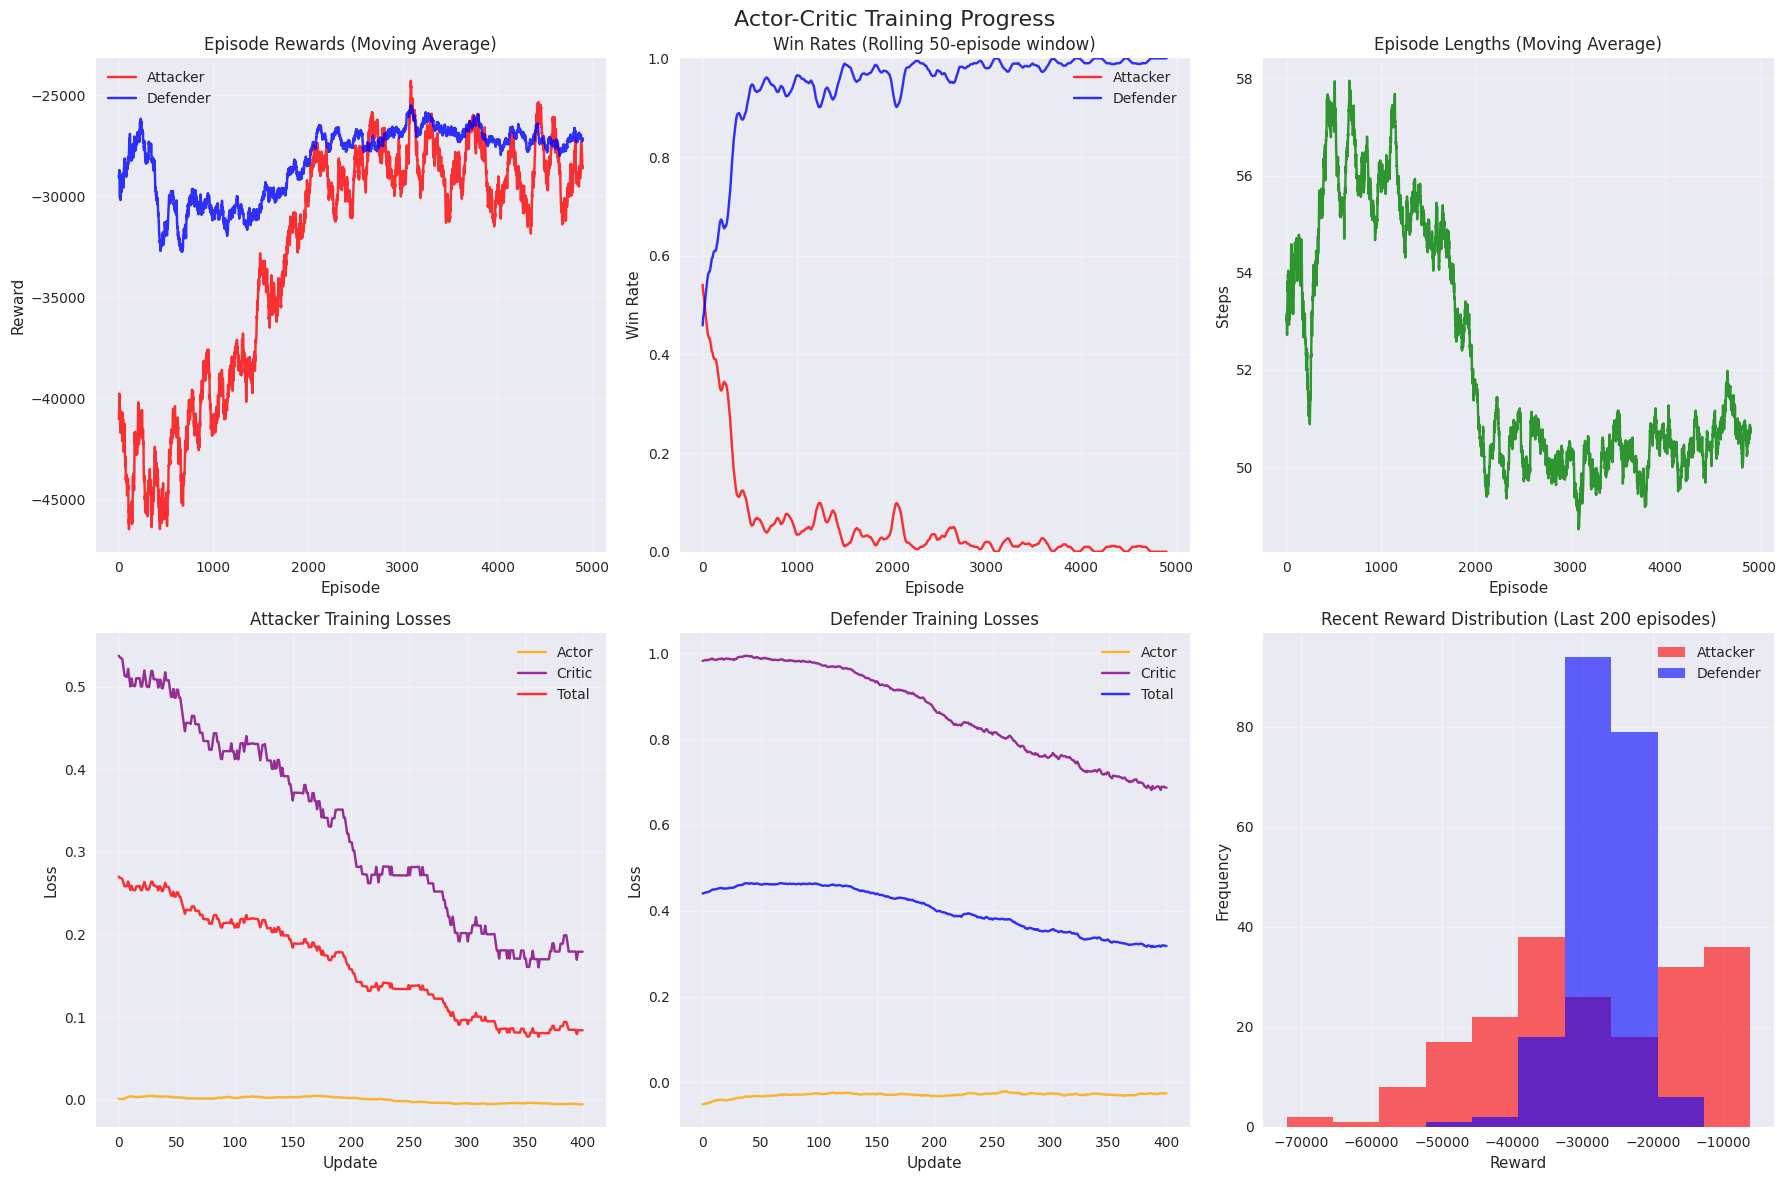


📈 FINAL TRAINING STATISTICS
Total Episodes Completed: 5000
Average Episode Length: 52.23 ± 7.75

🏆 FINAL PERFORMANCE (Last 200 episodes):
Attacker Win Rate: 0.00%
Defender Win Rate: 100.00%
Average Attacker Reward: -28878.10
Average Defender Reward: -27174.90
Average Episode Length: 50.77 steps

🎯 FINAL TRAINING LOSSES:
Attacker Final Loss: 0.0748
Defender Final Loss: 0.3068

📋 COMPREHENSIVE TRAINING SUMMARY:
TRAINING SUMMARY
Total Episodes: 5000
Average Episode Length: 52.23 ± 7.75

REWARDS:
  Attacker - Mean: -32942.076, Std: 17008.759
  Defender - Mean: -28204.104, Std: 6643.115

WIN RATES:
  Attacker: 5.4%
  Defender: 94.6%

RECENT PERFORMANCE (Last 100 episodes):
  Attacker - Mean Reward: -28578.200
  Defender - Mean Reward: -27146.600
  Attacker Win Rate: 0.0%
  Defender Win Rate: 100.0%


In [6]:
# Now use the separate plotting utility to generate visualizations
from plot_training_metrics import TrainingPlotter

# Create plotter instance
plotter = TrainingPlotter(f'training_logs/{env_name}_time_training_metrics.pkl')

# Generate comprehensive training progress plot
print("📊 Generating main training progress plot...")
plotter.plot_training_progress(
    save_path=f'training_logs/{env_name}_time_training_progress.png',
    show_plot=True
)

# Additional analysis using the metrics data directly
print(f"\n📈 FINAL TRAINING STATISTICS")
print(f"="*50)

total_episodes = len(metrics.episode_lengths)

# Overall statistics
print(f"Total Episodes Completed: {total_episodes}")
print(f"Average Episode Length: {np.mean(metrics.episode_lengths):.2f} ± {np.std(metrics.episode_lengths):.2f}")

# Final performance (last 200 episodes)
final_window = min(200, total_episodes)
final_stats = metrics.get_recent_stats(final_window)

print(f"\n🏆 FINAL PERFORMANCE (Last {final_window} episodes):")
print(f"Attacker Win Rate: {final_stats['attacker_win_rate']:.2%}")
print(f"Defender Win Rate: {final_stats['defender_win_rate']:.2%}")
print(f"Average Attacker Reward: {final_stats['avg_attacker_reward']:.2f}")
print(f"Average Defender Reward: {final_stats['avg_defender_reward']:.2f}")
print(f"Average Episode Length: {final_stats['avg_episode_length']:.2f} steps")

# Training stability analysis
if len(metrics.attacker_losses['total']) > 10:
    recent_att_loss = np.mean(metrics.attacker_losses['total'][-50:])
    recent_def_loss = np.mean(metrics.defender_losses['total'][-50:])
    print(f"\n🎯 FINAL TRAINING LOSSES:")
    print(f"Attacker Final Loss: {recent_att_loss:.4f}")
    print(f"Defender Final Loss: {recent_def_loss:.4f}")

# Print comprehensive summary
print(f"\n📋 COMPREHENSIVE TRAINING SUMMARY:")
plotter.print_training_summary()

## Model Testing and Evaluation

Test the trained models with a few evaluation games to verify performance.

In [7]:
# Test the trained models
print("🧪 Testing Trained Models")
print("="*50)

def test_trained_models(n_test_games=10):
    """Test the trained models with deterministic policies."""
    print(f"Running {n_test_games} test games with trained models...")
    
    test_results = {
        'attacker_rewards': [],
        'defender_rewards': [],
        'episode_lengths': [],
        'winners': []
    }
    
    for game in range(n_test_games):
        # Handle environment reset with proper error handling
        obs, info = env.reset()
        
        game_rewards = {'attacker': 0, 'defender': 0}
        step_count = 0
        
        for agent_name in env.agent_iter():
            if step_count > 50:  # Max steps limit
                break
                
            observation, reward, termination, truncation, info = env.last()
            game_rewards[agent_name] += reward
            
            if termination or truncation:
                env.step(None)
                break
            
            step_count += 1
            # Get available actions
            available_actions = env.get_available_actions(agent_name)
            
            if not available_actions:
                env.step(0)
                continue
            
            # Get deterministic action from trained agent
            if agent_name == 'attacker':
                action, _, _, _ = attacker_agent.get_action(observation, available_actions)
            else:
                action, _, _, _ = defender_agent.get_action(observation, available_actions)

            env.step(action)
        
        # Store results
        test_results['attacker_rewards'].append(game_rewards['attacker'])
        test_results['defender_rewards'].append(game_rewards['defender'])
        test_results['episode_lengths'].append(step_count)
        
        # if goal reached then the winner is the attacker
        if env.goal_reached:
            test_results['winners'].append('attacker')
        else:
            test_results['winners'].append('defender')
            
        print(f"Game {game+1:2d}: Att {game_rewards['attacker']:6.1f} | "
              f"Def {game_rewards['defender']:6.1f} | "
              f"Length: {step_count:2d} | "
              f"Winner: {test_results['winners'][-1]}")
    
    return test_results

# Run test games
test_results = test_trained_models(10)

# Analyze test results
print(f"\n🎯 TEST RESULTS SUMMARY:")
print(f"="*30)
print(f"Average Attacker Reward: {np.mean(test_results['attacker_rewards']):.2f}")
print(f"Average Defender Reward: {np.mean(test_results['defender_rewards']):.2f}")
print(f"Average Episode Length: {np.mean(test_results['episode_lengths']):.2f} steps")

attacker_wins = test_results['winners'].count('attacker')
defender_wins = test_results['winners'].count('defender')  
ties = test_results['winners'].count('tie')

print(f"Attacker Wins: {attacker_wins}/{len(test_results['winners'])} ({attacker_wins/len(test_results['winners']):.1%})")
print(f"Defender Wins: {defender_wins}/{len(test_results['winners'])} ({defender_wins/len(test_results['winners']):.1%})")
print(f"Ties: {ties}/{len(test_results['winners'])} ({ties/len(test_results['winners']):.1%})")

print(f"\n✅ Model testing complete!")

🧪 Testing Trained Models
Running 10 test games with trained models...
Game  1: Att -33880.0 | Def -28900.0 | Length: 51 | Winner: defender
Game  2: Att -15120.0 | Def -28520.0 | Length: 51 | Winner: defender
Game  3: Att -35280.0 | Def -28680.0 | Length: 51 | Winner: defender
Game  4: Att -10980.0 | Def -19960.0 | Length: 45 | Winner: defender
Game  5: Att -10320.0 | Def -23880.0 | Length: 45 | Winner: defender
Game  6: Att -41380.0 | Def -28620.0 | Length: 51 | Winner: defender
Game  7: Att -15120.0 | Def -28640.0 | Length: 51 | Winner: defender
Game  8: Att -34940.0 | Def -26620.0 | Length: 49 | Winner: defender
Game  9: Att -13080.0 | Def -28540.0 | Length: 51 | Winner: defender
Game 10: Att -12920.0 | Def -25280.0 | Length: 47 | Winner: defender

🎯 TEST RESULTS SUMMARY:
Average Attacker Reward: -22302.00
Average Defender Reward: -26764.00
Average Episode Length: 49.20 steps
Attacker Wins: 0/10 (0.0%)
Defender Wins: 10/10 (100.0%)
Ties: 0/10 (0.0%)

✅ Model testing complete!


In [8]:
def show_test_game(env, attacker_agent, defender_agent, max_steps=50):
    """Run and visualize a single test game with detailed step-by-step information."""
    
    obs, info = env.reset()

    print("\n🎮 GAME START")
    print("="*50)
    print(f"Initial state: {env.state if hasattr(env, 'state') else 'Unknown'}")
    print(f"Goal: {env.goal}")
    print(f"Initial goal state: {env.state.get(env.goal, 'Not in state')}")
    
    step_count = 0
    total_rewards = {'attacker': 0, 'defender': 0}
    
    for agent_name in env.agent_iter():
        observation, reward, termination, truncation, info = env.last()
        step_count += 1
        
        # Print step information
        print(f"\n⏱️  STEP {step_count} | Agent: {agent_name}")
        print(f"   Observation: {observation}")
        print(f"   Reward: {reward}")
        print(f"   Goal state: {env.state.get(env.goal, 'Not in state')}")
        # Get available actions
        available_actions = env.get_available_actions(agent_name)
        print(f"   Available actions: {available_actions}")
        
        total_rewards[agent_name] += reward
        
        # Get action from appropriate agent
        if agent_name == 'attacker':
            action, _, _, action_probs = attacker_agent.get_action(observation, available_actions, deterministic=True)
            print(f"   🔴 Attacker chose action: {env.get_action_name(action, agent_name)}")
        else:
            action, _, _, action_probs = defender_agent.get_action(observation, available_actions, deterministic=True)
            print(f"   🔵 Defender chose action: {env.get_action_name(action, agent_name)}")

        # Take action
        env.step(action)
        
        # Print current cumulative rewards
        print(f"   Cumulative rewards: Attacker: {total_rewards['attacker']}, Defender: {total_rewards['defender']}")
        
        if termination or truncation or step_count >= max_steps:
            print(f"   ⚠️  Game terminated: {termination}, truncated: {truncation}")
            break
        
        # Print state after action if available
        if hasattr(env, 'state'):
            print(f"   New state: {env.state}")
        

    
    # Game summary
    print("\n🏁 GAME SUMMARY")
    print("="*50)
    print(f"Game ended after {step_count} steps.")
    print(f"Final state: {env.state if hasattr(env, 'state') else 'Unknown'}")
    print(f"Final goal state: {env.state.get(env.goal, 'Not in state')}")
    
    # Determine winner based on final state
    final_goal_achieved = False
    if env.goal in env.state and env.state[env.goal] == 1:
        final_goal_achieved = True

    if final_goal_achieved:
        print("🎯 Attacker successfully achieved the goal!")
        winner = "attacker"
    else:
        print("🛡️ Defender successfully prevented the attack!")
        winner = "defender"
    
    print(f"Winner: {winner}")
    print(f"Final rewards: Attacker: {total_rewards['attacker']}, Defender: {total_rewards['defender']}")
    
show_test_game(env, attacker_agent, defender_agent)


🎮 GAME START
Initial state: {'root': 0, 'current_player': 0, 'N_6': 0, 'N_8': 0, 'N_3': 0, 'N_9': 0, 'N_11': 0, 'N_7': 0, 'N_13': 0, 'N_10': 0, 'N_12': 0, 'N_4': 0, 'N_2': 0, 'N_5': 0, 'N_1': 1, 'N_100': 1, 'N_101': 1, 'N_102': 1, 'N_103': 1, 'N_104': 1, 'N_105': 1, 'N_106': 1}
Goal: root
Initial goal state: 0

⏱️  STEP 1 | Agent: attacker
   Observation: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1 -1 -1]
   Reward: 0
   Goal state: 0
   Available actions: [4, 14, 15, 16, 17, 18, 19]
   🔴 Attacker chose action: a4
   Cumulative rewards: Attacker: 0, Defender: 0
   New state: {'root': 0, 'current_player': 0, 'N_6': 0, 'N_8': 0, 'N_3': 0, 'N_9': 0, 'N_11': 0, 'N_7': 0, 'N_13': 0, 'N_10': 0, 'N_12': 0, 'N_4': 0, 'N_2': 0, 'N_5': 0, 'N_1': 1, 'N_100': 1, 'N_101': 1, 'N_102': 1, 'N_103': 1, 'N_104': 1, 'N_105': 1, 'N_106': 1}

⏱️  STEP 2 | Agent: defender
   Observation: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  2 -1]
   Reward: 0
   Goal st